# The first step is -> Read the data
## We have already made this function 
## Read More: [Stock Markets](https://github.com/Masoud-Khosravi/Stock-Markets)

In [1]:
from ReadData import MetaTrader
import pandas as pd
import numpy as np

In [2]:
my_obj = MetaTrader("XAUUSD", "M15",count=6000)
if my_obj:
    print("Everything is fine.")
else:
    print("Entered Symbol <{}> is {}".format(my_obj.symbol, my_obj._symbol_exist))
    print("and Entered Timeframe is {}".format(my_obj.time_frame))

Everything is fine.


In [3]:
df_raw=my_obj.df_type1_raw

In [4]:
df_raw.tail()

,time,open,high,low,close,tick_volume,High9,High26,High52,Low9,Low26,Low52
5943,2022-12-23 19:30:00,1800.25,1801.06,1799.31,1799.32,924,1803.19,1803.19,1803.19,1798.11,1791.14,1791.14
5944,2022-12-23 19:45:00,1799.33,1799.63,1797.15,1797.24,1122,1803.19,1803.19,1803.19,1797.15,1791.14,1791.14
5945,2022-12-23 20:00:00,1797.25,1797.72,1796.33,1796.52,1065,1803.19,1803.19,1803.19,1796.33,1791.14,1791.14
5946,2022-12-23 20:15:00,1796.52,1797.44,1795.65,1796.22,1013,1803.19,1803.19,1803.19,1795.65,1791.14,1791.14
5947,2022-12-23 20:30:00,1796.24,1796.34,1794.14,1794.42,904,1803.19,1803.19,1803.19,1794.14,1791.14,1791.14


# Now it's time to make y_values
## in this part we create the y values
### our y values in this case is The closing price of the next candle
### and for best selection we use distance of next close price vs current close price
###  this_close - next_close  --> So 
+ if distance is positive means next candle is lower than this candle As long as the distance
+ if distance is negative means next candle is upper than this candle As long as the distance

## lets go  

In [5]:
def create_y(dataframe):
    """
    Please pass your raw dataframe
    exp:
  
    """
    df=dataframe.copy()
    
    #create an empty y values
    y = pd.DataFrame(np.nan,index=np.arange(len(df)),columns=["y_true"])
    y = df.apply(lambda row: df["close"][row.name]-df["close"][row.name+1] if row.name<(len(df)-1) else np.nan,axis=1)
    
    return y

In [6]:
y=create_y(df_raw)

## As you know we dont have y_true for last candle so --> drop it 

In [7]:
y=y[:-1]
df_raw=df_raw[:-1]

# now we can visulize data

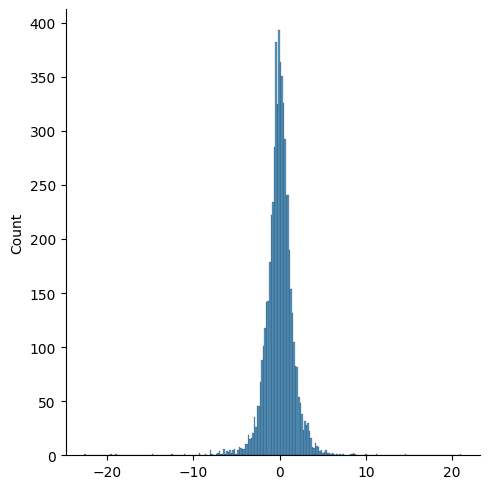

In [8]:
import seaborn as sns
sns.displot(y)

In [9]:
len(y[(y>=10) | (y<=-10)])

9

# OK, We have a small amount of outliers
## drop it

In [10]:
y=y[(y<10) & (y>-10)]

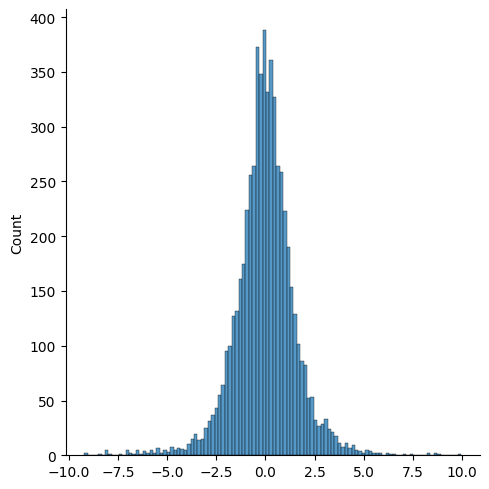

In [11]:
sns.displot(y)

In [12]:
print(len(df_raw))
print(len(y))

5947
5938


# we  should drop that columns from our df's too
## After we create y_values we pass normalized dataframe to models
### So we have normalized df:

In [13]:
df_raw=df_raw[df_raw.index.isin(y.index)]
df=my_obj.df_type1_changed
df=df[df.index.isin(y.index)]

In [14]:
print(len(df_raw))
print(len(df))
print(len(y))

5938
5938
5938


# Let's check the models:

In [15]:
from Learnings import Regression

In [16]:
Class_obj=Regression(df,y)

MAE= 1.1939106273132738
MSE= 3.1566096855135983
Root MSE= 1.7766850270978247


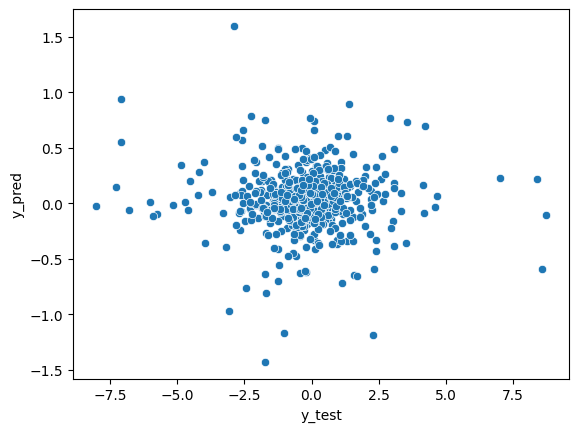

In [17]:
model=Class_obj.support_vector_regression()

Class_obj.evaluates.mean_errors()

Class_obj.evaluates.plot_df_y()

MAE= 1.7543939393939358
MSE= 6.282619023569
Root MSE= 2.5065153148482855


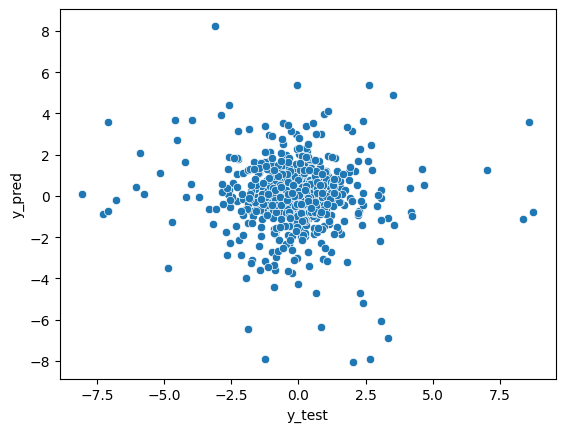

In [18]:
model=Class_obj.decision_tree_regressor()

Class_obj.evaluates.mean_errors()

Class_obj.evaluates.plot_df_y()

MAE= 1.180733031574766
MSE= 3.069928567196636
Root MSE= 1.7521211622478154


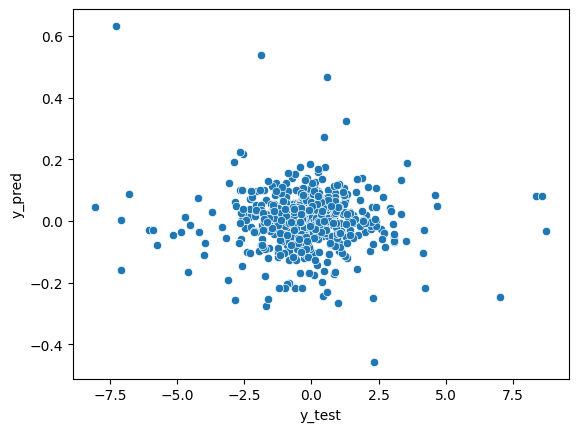

In [19]:
model=Class_obj.ridge()

Class_obj.evaluates.mean_errors()

Class_obj.evaluates.plot_df_y()

In [20]:
model=Class_obj.tensorflow()
Class_obj.evaluates.mean_errors()

19/19 [==============================] - 0s 444us/step
MAE= 1.1823947863737314
MSE= 2.963195423948473
Root MSE= 1.721393454137802


1.721393454137802

19/19 [==============================] - 0s 469us/step


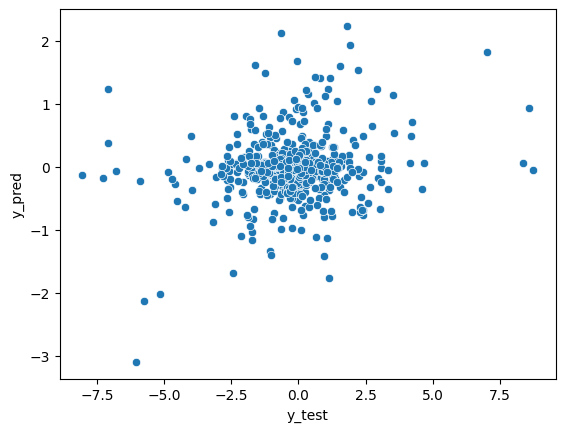

In [21]:
Class_obj.evaluates.plot_df_y()

In [22]:
df_y=Class_obj.df_y

In [23]:
df_y[df_y['y_pred']>=2]

,y_test,y_pred
133,-0.64,2.121977
412,1.80,2.241019


In [24]:
df_y[df_y['y_pred']<=-2]

,y_test,y_pred
26,-5.76,-2.125479
325,-6.03,-3.100143
389,-5.14,-2.013447


# Now After Evaluating models we could use one of theme to get signal of last candle
## for  example our last model is tensorflow
## so after we got last candle data we can predict from model
# lets go

In [25]:
# updating Last candle data
if my_obj.update_last():
    print('Everything good')

Everything good


In [26]:
last_candle=my_obj.df_last_candle_type1_changed
last_candle

,time,open,high,low,tick_volume,High9,High26,High52,Low9,Low26,Low52
0,1.246084,-1.103908,-0.718748,-0.682995,-0.667372,-1.598533,-0.505768,0.012755,-0.847,-0.481427,-0.68239


In [27]:
last_signal=model.predict(last_candle)
last_signal

1/1 [==============================] - 0s 10ms/step


array([[0.15859278]], dtype=float32)

In [28]:
if Class_obj.is_tensor:
    last_signal=pd.Series(last_signal.reshape(1, ))
print('The Last close distance from this Close is:',last_signal[0])
this_close=my_obj.df_last_candle_type1.close[0]
print ('This Close is:',this_close)
print('Next close Should be:',round(this_close-last_signal[0],2))

The Last close distance from this Close is: 0.15859278
This Close is: 1794.42
Next close Should be: 1794.26
